<a href="https://colab.research.google.com/github/mukunthans/DLAssignment1/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import numpy as np
import pandas as pd
import wandb


In [11]:

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

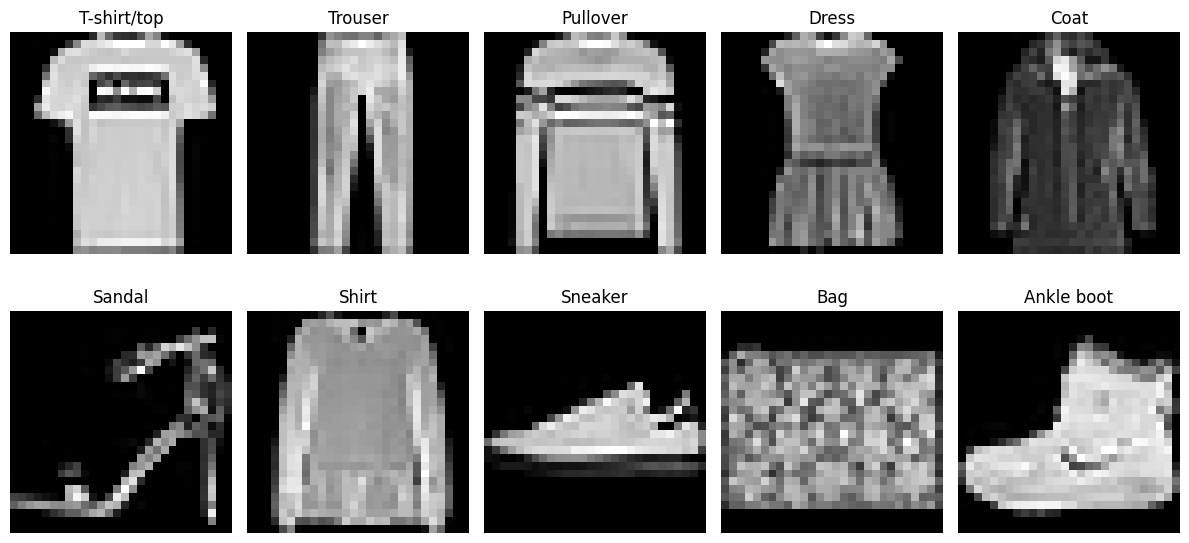

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for class_idx in range(10):
    idx = np.where(y_train == class_idx)[0][0]
    image = x_train[idx]
    axes[class_idx].imshow(image, cmap='gray')
    axes[class_idx].set_title(class_names[class_idx])
    axes[class_idx].axis('off')

plt.tight_layout()
plt.show()

In [2]:
# Identity Activation Function
def identity(x):
    return x

# Sigmoid Activation Function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Tanh Activation Function
def tanh(x):
    return np.tanh(x)

# ReLU Activation Function
def relu(x):
    return np.maximum(0, x)


In [18]:
class Feed_Forward:
    def __init__(self, hidden_units, num_hidden_layers, input_dim, output_dim,
                 weight_init="random", output_activation="softmax", initialize=True):
        self.hidden_units = hidden_units
        self.num_hidden_layers = num_hidden_layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight_init_type = weight_init
        self.output_activation_type = output_activation

        self.weights, self.biases = [], []
        if initialize:
            self.initialize_parameters()

    def initialize_parameters(self):
        # Initialize weights for input, hidden, and output layers
        self.weights.append(np.random.randn(self.input_dim, self.hidden_units))
        for _ in range(self.num_hidden_layers - 1):
            self.weights.append(np.random.randn(self.hidden_units, self.hidden_units))
        self.weights.append(np.random.randn(self.hidden_units, self.output_dim))
        if self.weight_init_type.lower() == "xavier":
            for i in range(len(self.weights)):
                self.weights[i] *= np.sqrt(1 / self.weights[i].shape[0])
        # Initialize biases for hidden and output layers
        self.biases = [np.zeros(self.hidden_units) for _ in range(self.num_hidden_layers)]
        self.biases.append(np.zeros(self.output_dim))

    def predict(self, x, activation_func):
        a = x
        for i in range(self.num_hidden_layers):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            a = activation_func(z)
        z = np.dot(a, self.weights[-1]) + self.biases[-1]
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)


In [10]:
def compute_loss(loss_type, y, y_pred):
    if loss_type == "cross_entropy":
        return -np.sum(y * np.log(y_pred))  # Cross Entropy Loss
    elif loss_type == "mean_squared_error":
        return 0.5 * np.sum((y - y_pred) ** 2)  # Mean Squared Error Loss


In [16]:
class Optimizer():
    def __init__(self, nn, lr, optimizer, momentum, epsilon, beta, beta1, beta2, t, decay):
        self.nn = nn
        self.lr = lr
        self.optimizer = optimizer
        self.momentum = momentum
        self.epsilon = epsilon
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.t = t
        self.decay = decay
        self.v_w = [np.zeros_like(w) for w in nn.weights]
        self.v_b = [np.zeros_like(b) for b in nn.biases]
        self.s_w = [np.zeros_like(w) for w in nn.weights]
        self.s_b = [np.zeros_like(b) for b in nn.biases]
    def SGD(self, d_weights, d_biases):
        for i in range(len(self.nn.weights)):
            self.nn.weights[i] -= self.lr * (d_weights[i] + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (d_biases[i] + self.decay * self.nn.biases[i])
    def MomentumGD(self, d_weights, d_biases):
        for i in range(len(self.nn.weights)):
            self.v_w[i] = self.momentum * self.v_w[i] + d_weights[i]
            self.v_b[i] = self.momentum * self.v_b[i] + d_biases[i]
            self.nn.weights[i] -= self.lr * (self.v_w[i] + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (self.v_b[i] + self.decay * self.nn.biases[i])
    def NAG(self, d_weights, d_biases):
        for i in range(len(self.nn.weights)):
            self.v_w[i] = self.momentum * self.v_w[i] + d_weights[i]
            self.v_b[i] = self.momentum * self.v_b[i] + d_biases[i]
            self.nn.weights[i] -= self.lr * (self.momentum * self.v_w[i] + d_weights[i] + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (self.momentum * self.v_b[i] + d_biases[i] + self.decay * self.nn.biases[i])
    def RMSProp(self, d_weights, d_biases):
        for i in range(len(self.nn.weights)):
            self.s_w[i] = self.beta * self.s_w[i] + (1 - self.beta) * (d_weights[i] ** 2)
            self.s_b[i] = self.beta * self.s_b[i] + (1 - self.beta) * (d_biases[i] ** 2)
            self.nn.weights[i] -= self.lr * (d_weights[i] / (np.sqrt(self.s_w[i]) + self.epsilon) + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (d_biases[i] / (np.sqrt(self.s_b[i]) + self.epsilon) + self.decay * self.nn.biases[i])
    def Adam(self, d_weights, d_biases):
        self.t += 1
        for i in range(len(self.nn.weights)):
            self.v_w[i] = self.beta1 * self.v_w[i] + (1 - self.beta1) * d_weights[i]
            self.v_b[i] = self.beta1 * self.v_b[i] + (1 - self.beta1) * d_biases[i]
            self.s_w[i] = self.beta2 * self.s_w[i] + (1 - self.beta2) * (d_weights[i] ** 2)
            self.s_b[i] = self.beta2 * self.s_b[i] + (1 - self.beta2) * (d_biases[i] ** 2)
            v_w_hat = self.v_w[i] / (1 - self.beta1 ** self.t)
            v_b_hat = self.v_b[i] / (1 - self.beta1 ** self.t)
            s_w_hat = self.s_w[i] / (1 - self.beta2 ** self.t)
            s_b_hat = self.s_b[i] / (1 - self.beta2 ** self.t)
            self.nn.weights[i] -= self.lr * (v_w_hat / (np.sqrt(s_w_hat) + self.epsilon) + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (v_b_hat / (np.sqrt(s_b_hat) + self.epsilon) + self.decay * self.nn.biases[i])
    def NAdam(self, d_weights, d_biases):
        self.t += 1
        for i in range(len(self.nn.weights)):
            self.v_w[i] = self.beta1 * self.v_w[i] + (1 - self.beta1) * d_weights[i]
            self.v_b[i] = self.beta1 * self.v_b[i] + (1 - self.beta1) * d_biases[i]
            self.s_w[i] = self.beta2 * self.s_w[i] + (1 - self.beta2) * (d_weights[i] ** 2)
            self.s_b[i] = self.beta2 * self.s_b[i] + (1 - self.beta2) * (d_biases[i] ** 2)
            v_w_hat = self.v_w[i] / (1 - self.beta1 ** self.t)
            v_b_hat = self.v_b[i] / (1 - self.beta1 ** self.t)
            s_w_hat = self.s_w[i] / (1 - self.beta2 ** self.t)
            s_b_hat = self.s_b[i] / (1 - self.beta2 ** self.t)
            nesterov_v_w = self.beta1 * v_w_hat + (1 - self.beta1) * d_weights[i] / (1 - self.beta1 ** self.t)
            nesterov_v_b = self.beta1 * v_b_hat + (1 - self.beta1) * d_biases[i] / (1 - self.beta1 ** self.t)
            self.nn.weights[i] -= self.lr * (nesterov_v_w / (np.sqrt(s_w_hat) + self.epsilon) + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (nesterov_v_b / (np.sqrt(s_b_hat) + self.epsilon) + self.decay * self.nn.biases[i])
    def optimize(self, d_weights, d_biases):
        opts = {
            "sgd": self.SGD,
            "momentum": self.MomentumGD,
            "nag": self.NAG,
            "rmsprop": self.RMSProp,
            "adam": self.Adam,
            "nadam": self.NAdam
        }
        opt_key = self.optimizer
        if opt_key == "nesterov":
            opt_key = "nag"
        opts[opt_key](d_weights, d_biases)


class NeuralNetworkTrainer:
    def __init__(self, nn, loss="cross_entropy", act_func="sigmoid", lr=0.001,
                 optimizer="sgd", momentum=0.9, epsilon=1e-8, beta=0.9, beta1=0.9, beta2=0.999, t=0, decay=0):
        self.nn = nn
        self.loss = loss
        self.activation_function = act_func
        self.lr = lr
        self.optimizer = optimizer
        self.momentum = momentum
        self.epsilon = epsilon
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.t = t
        self.decay = decay

        # Initialize optimizer instance with trainer parameters.
        self.optimizer_instance = Optimizer(nn, lr, optimizer, momentum, epsilon, beta, beta1, beta2, t, decay)

    def output_activation_derivative(self, y_pred):
        return np.diag(y_pred) - np.outer(y_pred, y_pred) if self.nn.output_activation_type == "softmax" else None

    def backward(self, y, y_pred):
        d_weights, d_biases, d_h, d_a = [], [], [], []
        d_h.append(y_pred - y)
        d_a.append(np.array([np.matmul((y_pred[i] - y[i]), self.output_activation_derivative(y_pred[i]))
                               for i in range(y_pred.shape[0])]))
        for i in range(self.nn.num_hidden_layers, 0, -1):
            d_weights.append(np.matmul(self.nn.post_activation[i].T, d_a[-1]))
            d_biases.append(np.sum(d_a[-1], axis=0))
            d_h.append(np.matmul(d_a[-1], self.nn.weights[i].T))
            d_a.append(d_h[-1] * self.activation_derivative(self.nn.post_activation[i]))
        d_weights.append(np.matmul(self.nn.post_activation[0].T, d_a[-1]))
        d_biases.append(np.sum(d_a[-1], axis=0))
        d_weights.reverse()
        d_biases.reverse()
        for i in range(len(d_weights)):
            d_weights[i] /= y.shape[0]
            d_biases[i] /= y.shape[0]
        return d_weights, d_biases

    def optimize(self, d_weights, d_biases):
        self.optimizer_instance.optimize(d_weights, d_biases)


In [19]:
x_test_flat = x_test.reshape(x_test.shape[0], -1) / 255.0
nn = Feed_Forward(hidden_units=128, num_hidden_layers=1, input_dim=784, output_dim=10,
                  weight_init="xavier", output_activation="softmax", initialize=True)

probabilities = nn.predict(x_test_flat, sigmoid)
print(probabilities[0])

[0.12307798 0.10917531 0.04226101 0.17151761 0.11046188 0.08531009
 0.13378174 0.05054072 0.11310158 0.06077207]


In [15]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m026 (cs24m026-iit-madras-foundation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import fashion_mnist, mnist
import wandb

# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def tanh(x):
    return np.tanh(x)
def relu(x):
    return np.maximum(0, x)

# Feed-Forward Neural Network (stores activations for backprop)
class Feed_Forward:
    def __init__(self, hidden_units, num_hidden_layers, input_dim, output_dim,
                 weight_init="random", output_activation="softmax", initialize=True):
        self.hidden_units = hidden_units
        self.num_hidden_layers = num_hidden_layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight_init_type = weight_init
        self.output_activation_type = output_activation
        self.weights, self.biases = [], []
        if initialize:
            self.initialize_parameters()

    def initialize_parameters(self):
        self.weights.append(np.random.randn(self.input_dim, self.hidden_units))
        for _ in range(self.num_hidden_layers - 1):
            self.weights.append(np.random.randn(self.hidden_units, self.hidden_units))
        self.weights.append(np.random.randn(self.hidden_units, self.output_dim))
        if self.weight_init_type.lower() == "xavier":
            for i in range(len(self.weights)):
                self.weights[i] *= np.sqrt(1 / self.weights[i].shape[0])
        self.biases = [np.zeros(self.hidden_units) for _ in range(self.num_hidden_layers)]
        self.biases.append(np.zeros(self.output_dim))

    def predict(self, x, activation_func):
        self.pre_activation = [x]
        self.post_activation = [x]
        a = x
        for i in range(self.num_hidden_layers):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            self.pre_activation.append(z)
            a = activation_func(z)
            self.post_activation.append(a)
        z = np.dot(a, self.weights[-1]) + self.biases[-1]
        self.pre_activation.append(z)
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        a_out = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        self.post_activation.append(a_out)
        return a_out

def loss_func(loss_type, y, y_pred):
    if loss_type == "cross_entropy":
        return -np.sum(y * np.log(y_pred))
    elif loss_type == "mean_squared_error":
        return np.sum((y - y_pred)**2) / 2
    else:
        raise Exception("Invalid loss function")

def get_activation_derivative(a, activation):
    if activation == "sigmoid":
        return a * (1 - a)
    elif activation == "tanh":
        return 1 - a**2
    elif activation == "relu":
        return (a > 0).astype(int)
    else:
        return np.ones(a.shape)

# Optimizer class (unchanged)
class Optimizer():
    def __init__(self, nn, lr, optimizer, momentum, epsilon, beta, beta1, beta2, t, decay):
        self.nn = nn
        self.lr = lr
        self.optimizer = optimizer
        self.momentum = momentum
        self.epsilon = epsilon
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.t = t
        self.decay = decay
        self.v_w = [np.zeros_like(w) for w in nn.weights]
        self.v_b = [np.zeros_like(b) for b in nn.biases]
        self.s_w = [np.zeros_like(w) for w in nn.weights]
        self.s_b = [np.zeros_like(b) for b in nn.biases]
    def SGD(self, d_weights, d_biases):
        for i in range(len(self.nn.weights)):
            self.nn.weights[i] -= self.lr * (d_weights[i] + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (d_biases[i] + self.decay * self.nn.biases[i])
    def MomentumGD(self, d_weights, d_biases):
        for i in range(len(self.nn.weights)):
            self.v_w[i] = self.momentum * self.v_w[i] + d_weights[i]
            self.v_b[i] = self.momentum * self.v_b[i] + d_biases[i]
            self.nn.weights[i] -= self.lr * (self.v_w[i] + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (self.v_b[i] + self.decay * self.nn.biases[i])
    def NAG(self, d_weights, d_biases):
        for i in range(len(self.nn.weights)):
            self.v_w[i] = self.momentum * self.v_w[i] + d_weights[i]
            self.v_b[i] = self.momentum * self.v_b[i] + d_biases[i]
            self.nn.weights[i] -= self.lr * (self.momentum * self.v_w[i] + d_weights[i] + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (self.momentum * self.v_b[i] + d_biases[i] + self.decay * self.nn.biases[i])
    def RMSProp(self, d_weights, d_biases):
        for i in range(len(self.nn.weights)):
            self.s_w[i] = self.beta * self.s_w[i] + (1 - self.beta) * (d_weights[i] ** 2)
            self.s_b[i] = self.beta * self.s_b[i] + (1 - self.beta) * (d_biases[i] ** 2)
            self.nn.weights[i] -= self.lr * (d_weights[i] / (np.sqrt(self.s_w[i]) + self.epsilon) + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (d_biases[i] / (np.sqrt(self.s_b[i]) + self.epsilon) + self.decay * self.nn.biases[i])
    def Adam(self, d_weights, d_biases):
        self.t += 1
        for i in range(len(self.nn.weights)):
            self.v_w[i] = self.beta1 * self.v_w[i] + (1 - self.beta1) * d_weights[i]
            self.v_b[i] = self.beta1 * self.v_b[i] + (1 - self.beta1) * d_biases[i]
            self.s_w[i] = self.beta2 * self.s_w[i] + (1 - self.beta2) * (d_weights[i] ** 2)
            self.s_b[i] = self.beta2 * self.s_b[i] + (1 - self.beta2) * (d_biases[i] ** 2)
            v_w_hat = self.v_w[i] / (1 - self.beta1 ** self.t)
            v_b_hat = self.v_b[i] / (1 - self.beta1 ** self.t)
            s_w_hat = self.s_w[i] / (1 - self.beta2 ** self.t)
            s_b_hat = self.s_b[i] / (1 - self.beta2 ** self.t)
            self.nn.weights[i] -= self.lr * (v_w_hat / (np.sqrt(s_w_hat) + self.epsilon) + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (v_b_hat / (np.sqrt(s_b_hat) + self.epsilon) + self.decay * self.nn.biases[i])
    def NAdam(self, d_weights, d_biases):
        self.t += 1
        for i in range(len(self.nn.weights)):
            self.v_w[i] = self.beta1 * self.v_w[i] + (1 - self.beta1) * d_weights[i]
            self.v_b[i] = self.beta1 * self.v_b[i] + (1 - self.beta1) * d_biases[i]
            self.s_w[i] = self.beta2 * self.s_w[i] + (1 - self.beta2) * (d_weights[i] ** 2)
            self.s_b[i] = self.beta2 * self.s_b[i] + (1 - self.beta2) * (d_biases[i] ** 2)
            v_w_hat = self.v_w[i] / (1 - self.beta1 ** self.t)
            v_b_hat = self.v_b[i] / (1 - self.beta1 ** self.t)
            s_w_hat = self.s_w[i] / (1 - self.beta2 ** self.t)
            s_b_hat = self.s_b[i] / (1 - self.beta2 ** self.t)
            nesterov_v_w = self.beta1 * v_w_hat + (1 - self.beta1) * d_weights[i] / (1 - self.beta1 ** self.t)
            nesterov_v_b = self.beta1 * v_b_hat + (1 - self.beta1) * d_biases[i] / (1 - self.beta1 ** self.t)
            self.nn.weights[i] -= self.lr * (nesterov_v_w / (np.sqrt(s_w_hat) + self.epsilon) + self.decay * self.nn.weights[i])
            self.nn.biases[i] -= self.lr * (nesterov_v_b / (np.sqrt(s_b_hat) + self.epsilon) + self.decay * self.nn.biases[i])
    def optimize(self, d_weights, d_biases):
        opts = {
            "sgd": self.SGD,
            "momentum": self.MomentumGD,
            "nag": self.NAG,
            "rmsprop": self.RMSProp,
            "adam": self.Adam,
            "nadam": self.NAdam
        }
        opt_key = self.optimizer
        if opt_key == "nesterov":
            opt_key = "nag"
        opts[opt_key](d_weights, d_biases)

class NeuralNetworkTrainer:
    def __init__(self, nn, loss="cross_entropy", act_func="sigmoid", lr=0.001, optimizer="sgd", momentum=0.9, epsilon=1e-8, beta=0.9, beta1=0.9, beta2=0.999, t=0, decay=0):
        self.nn = nn
        self.loss = loss
        self.activation_function = act_func
        self.lr = lr
        self.optimizer = optimizer
        self.momentum = momentum
        self.epsilon = epsilon
        self.beta = beta
        self.beta1 = beta1
        self.beta2 = beta2
        self.t = t
        self.decay = decay
        self.optimizer_instance = Optimizer(nn, lr, optimizer, momentum, epsilon, beta, beta1, beta2, t, decay)
    def output_activation_derivative(self, y_pred):
        return np.diag(y_pred) - np.outer(y_pred, y_pred) if self.nn.output_activation_type == "softmax" else None
    def activation_derivative(self, a):
        return get_activation_derivative(a, self.activation_function)
    def backward(self, y, y_pred):
        d_weights, d_biases, d_h, d_a = [], [], [], []
        d_h.append(y_pred - y)
        d_a.append(np.array([np.matmul((y_pred[i] - y[i]), self.output_activation_derivative(y_pred[i]))
                               for i in range(y_pred.shape[0])]))
        for i in range(self.nn.num_hidden_layers, 0, -1):
            d_weights.append(np.matmul(self.nn.post_activation[i].T, d_a[-1]))
            d_biases.append(np.sum(d_a[-1], axis=0))
            d_h.append(np.matmul(d_a[-1], self.nn.weights[i].T))
            d_a.append(d_h[-1] * self.activation_derivative(self.nn.post_activation[i]))
        d_weights.append(np.matmul(self.nn.post_activation[0].T, d_a[-1]))
        d_biases.append(np.sum(d_a[-1], axis=0))
        d_weights.reverse()
        d_biases.reverse()
        for i in range(len(d_weights)):
            d_weights[i] /= y.shape[0]
            d_biases[i] /= y.shape[0]
        return d_weights, d_biases
    def optimize(self, d_weights, d_biases):
        self.optimizer_instance.optimize(d_weights, d_biases)

sweep_configuration = {
    'method': 'random',
    'name': 'fashion_mnist_sweep',
    'metric': {
        'goal': 'maximize',
        'name': 'val_accuracy'
    },
    'parameters': {
        'epochs': {'values': [5, 10]},
        'hidden_layers': {'values': [3, 4, 5]},
        'neurons': {'values': [32, 64, 128]},
        'decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [1e-3, 1e-4]},
        'optimizer': {'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']},
        'momentum': {'values': [0.7, 0.8, 0.9]},
        'input_size': {'value': 784},
        'output_size': {'value': 10},
        'loss': {'value': 'mean_squared_error'},
        'beta': {'value': 0.9},
        'beta1': {'value': 0.9},
        'beta2': {'value': 0.999},
        'output_activation': {'value': 'softmax'},
        'epsilon': {'value': 1e-8},
        'dataset': {'value': 'fashion_mnist'}
    }
}

def load_data(type, dataset='fashion_mnist'):
    x, y, x_test, y_test = None, None, None, None
    if dataset == 'mnist':
        (x, y), (x_test, y_test) = mnist.load_data()
    elif dataset == 'fashion_mnist':
        (x, y), (x_test, y_test) = fashion_mnist.load_data()
    if type == 'train':
        x = x.reshape(x.shape[0], 784) / 255.0
        y = np.eye(10)[y]
        return x, y
    elif type == 'test':
        x_test = x_test.reshape(x_test.shape[0], 784) / 255.0
        y_test = np.eye(10)[y_test]
        return x_test, y_test

def train_sweep():
    run = wandb.init()
    parameters = wandb.config
    run.name = f"{parameters['activation']}_neurons={parameters['neurons']}_layers={parameters['hidden_layers']}_lr={parameters['learning_rate']}_batch={parameters['batch_size']}_opt={parameters['optimizer']}_mom={parameters['momentum']}_init={parameters['weight_init']}"
    x_train, y_train = load_data('train', dataset=parameters['dataset'])

    act_funcs = {'sigmoid': sigmoid, 'tanh': tanh, 'relu': relu}
    act_func = act_funcs[parameters['activation']]

    nn = Feed_Forward(hidden_units=parameters['neurons'],
                      num_hidden_layers=parameters['hidden_layers'],
                      input_dim=parameters['input_size'],
                      output_dim=parameters['output_size'],
                      weight_init=parameters['weight_init'],
                      output_activation=parameters['output_activation'],
                      initialize=True)
    # NeuralNetworkTrainer now includes backward functionality
    trainer = NeuralNetworkTrainer(nn=nn,
                                   loss=parameters['loss'],
                                   act_func=parameters['activation'],
                                   lr=parameters['learning_rate'],
                                   optimizer=parameters['optimizer'],
                                   momentum=parameters['momentum'],
                                   epsilon=parameters['epsilon'],
                                   beta=parameters['beta'],
                                   beta1=parameters['beta1'],
                                   beta2=parameters['beta2'],
                                   t=0,
                                   decay=parameters['decay'])
    batch_size = parameters['batch_size']
    x_train_act, x_val, y_train_act, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
    print("Initial Accuracy: {}".format(np.sum(np.argmax(nn.predict(x_train, act_func), axis=1) == np.argmax(y_train, axis=1)) / y_train.shape[0]))
    for epoch in range(parameters['epochs']):
        for i in range(0, x_train_act.shape[0], batch_size):
            x_batch = x_train_act[i:i+batch_size]
            y_batch = y_train_act[i:i+batch_size]
            y_pred = nn.predict(x_batch, act_func)
            d_weights, d_biases = trainer.backward(y_batch, y_pred)
            trainer.optimize(d_weights, d_biases)
        trainer.optimizer_instance.t += 1
        y_pred_train = nn.predict(x_train_act, act_func)
        print("Epoch: {}, Loss: {}".format(epoch + 1, loss_func(parameters['loss'], y_train_act, y_pred_train)))
        print("Accuracy: {}".format(np.sum(np.argmax(y_pred_train, axis=1) == np.argmax(y_train_act, axis=1)) / y_train_act.shape[0]))
        train_loss = loss_func(parameters['loss'], y_train_act, y_pred_train)
        train_accuracy = np.sum(np.argmax(y_pred_train, axis=1) == np.argmax(y_train_act, axis=1)) / y_train_act.shape[0]
        y_pred_val = nn.predict(x_val, act_func)
        val_loss = loss_func(parameters['loss'], y_val, y_pred_val) / x_val.shape[0]
        val_accuracy = np.sum(np.argmax(y_pred_val, axis=1) == np.argmax(y_val, axis=1)) / y_val.shape[0]
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_accuracy,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy
        })
    x_test, y_test = load_data('test', dataset=parameters['dataset'])
    y_pred_test = nn.predict(x_test, act_func)
    test_loss = loss_func(parameters['loss'], y_test, y_pred_test)
    test_accuracy = np.sum(np.argmax(y_pred_test, axis=1) == np.argmax(y_test, axis=1)) / y_test.shape[0]
    print("Test Accuracy: {}".format(test_accuracy))
    wandb.log({
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    })
    return nn

wandb.login()
wandb_id = wandb.sweep(sweep_configuration, project="SWEEP_PROJECT1")
wandb.agent(wandb_id, function=train_sweep, count=50)
wandb.finish()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m026 (cs24m026-iit-madras-foundation) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Create sweep with ID: xl0du6uy
Sweep URL: https://wandb.ai/cs24m026-iit-madras-foundation/SWEEP_PROJECT1/sweeps/xl0du6uy


wandb: Agent Starting Run: n0yrweps with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 32
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Initial Accuracy: 0.1312
Epoch: 1, Loss: 7504.076276137899
Accuracy: 0.8096851851851852
Epoch: 2, Loss: 6546.289697839059
Accuracy: 0.8352222222222222
Epoch: 3, Loss: 6016.9986281341635
Accuracy: 0.8497222222222223
Epoch: 4, Loss: 5694.766811523606
Accuracy: 0.858537037037037
Epoch: 5, Loss: 5454.728881821164
Accuracy: 0.8649629629629629
Test Accuracy: 0.8423


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▇██
val_loss,█▅▃▂▁
epoch,5
test_accuracy,0.8423
test_loss,1129.27508
train_accuracy,0.86496


wandb: Agent Starting Run: f25jlbi2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 64
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.10678333333333333
Epoch: 1, Loss: 6631.175460536891
Accuracy: 0.8334074074074074
Epoch: 2, Loss: 5848.727402194049
Accuracy: 0.8542777777777778
Epoch: 3, Loss: 5459.5591646980765
Accuracy: 0.8629814814814815
Epoch: 4, Loss: 5193.018718242788
Accuracy: 0.8707592592592592
Epoch: 5, Loss: 4987.701553245826
Accuracy: 0.8763703703703704
Epoch: 6, Loss: 4844.367169749947
Accuracy: 0.8801111111111111
Epoch: 7, Loss: 4727.180580982275
Accuracy: 0.8830185185185185
Epoch: 8, Loss: 4626.509948294378
Accuracy: 0.8857777777777778
Epoch: 9, Loss: 4547.472794498386
Accuracy: 0.8877592592592592
Epoch: 10, Loss: 4459.40421824508
Accuracy: 0.8897037037037037
Test Accuracy: 0.8657


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8657
test_loss,998.49981
train_accuracy,0.8897


wandb: Agent Starting Run: pq3hu1gw with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.8
wandb: 	neurons: 64
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.09251666666666666
Epoch: 1, Loss: 24309.015485408774
Accuracy: 0.09607407407407408
Epoch: 2, Loss: 24274.933959979517
Accuracy: 0.0971111111111111
Epoch: 3, Loss: 24284.183388882768
Accuracy: 0.09764814814814815
Epoch: 4, Loss: 24292.80369941544
Accuracy: 0.09805555555555556
Epoch: 5, Loss: 24297.08311393919
Accuracy: 0.10875925925925926
Test Accuracy: 0.1038


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▂▂█
train_loss,█▁▃▅▆
val_accuracy,▃▂▂▁█
val_loss,█▁▃▄▅
epoch,5
test_accuracy,0.1038
test_loss,4499.47519
train_accuracy,0.10876


wandb: Agent Starting Run: uze7pkcg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.04685
Epoch: 1, Loss: 6631.772899161653
Accuracy: 0.8285740740740741
Epoch: 2, Loss: 5351.460213791437
Accuracy: 0.8625
Epoch: 3, Loss: 5026.655462335756
Accuracy: 0.8721851851851852
Epoch: 4, Loss: 4962.921336594169
Accuracy: 0.8733148148148148
Epoch: 5, Loss: 5025.834116277546
Accuracy: 0.8736666666666667
Test Accuracy: 0.8531


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆███
train_loss,█▃▁▁▁
val_accuracy,▁▆███
val_loss,█▂▁▁▂
epoch,5
test_accuracy,0.8531
test_loss,1081.07998
train_accuracy,0.87367


wandb: Agent Starting Run: t0aclqzr with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 12362.269153535683
Accuracy: 0.6661666666666667
Epoch: 2, Loss: 9203.743883881472
Accuracy: 0.7637962962962963
Epoch: 3, Loss: 7874.082600553604
Accuracy: 0.7907962962962963
Epoch: 4, Loss: 7256.04491199089
Accuracy: 0.8072962962962963
Epoch: 5, Loss: 6854.718503097769
Accuracy: 0.8203888888888888
Test Accuracy: 0.8058


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▆▇▇█
val_loss,█▄▂▂▁
epoch,5
test_accuracy,0.8058
test_loss,1358.84038
train_accuracy,0.82039


wandb: Agent Starting Run: emr676my with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.7
wandb: 	neurons: 32
wandb: 	optimizer: nesterov
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.10223333333333333
Epoch: 1, Loss: 24256.893554190927
Accuracy: 0.10488888888888889
Epoch: 2, Loss: 24227.817931611764
Accuracy: 0.10644444444444444
Epoch: 3, Loss: 24203.550014608467
Accuracy: 0.10796296296296297
Epoch: 4, Loss: 24181.40715851684
Accuracy: 0.10974074074074074
Epoch: 5, Loss: 24160.05874732834
Accuracy: 0.11183333333333334
Epoch: 6, Loss: 24138.950158736883
Accuracy: 0.11448148148148148
Epoch: 7, Loss: 24117.610862495618
Accuracy: 0.11796296296296296
Epoch: 8, Loss: 24095.83261113985
Accuracy: 0.12233333333333334
Epoch: 9, Loss: 24073.424487942226
Accuracy: 0.12775925925925927
Epoch: 10, Loss: 24050.265239023
Accuracy: 0.13453703703703704
Test Accuracy: 0.1311


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▂▂▃▃▄▅▆█
train_loss,█▇▆▅▅▄▃▃▂▁
val_accuracy,▁▂▂▃▃▃▄▅▆█
val_loss,█▇▆▅▅▄▃▃▂▁
epoch,10
test_accuracy,0.1311
test_loss,4454.91387
train_accuracy,0.13454


wandb: Agent Starting Run: b2cc2rtb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 64
wandb: 	optimizer: nesterov
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 24773.818234212897
Accuracy: 0.09985185185185186
Epoch: 2, Loss: 24613.827541702016
Accuracy: 0.09985185185185186
Epoch: 3, Loss: 24520.978629260982
Accuracy: 0.09985185185185186
Epoch: 4, Loss: 24461.132626104598
Accuracy: 0.09985185185185186
Epoch: 5, Loss: 24418.3812181148
Accuracy: 0.09985185185185186
Test Accuracy: 0.1


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▁▁▁
train_loss,█▅▃▂▁
val_accuracy,▁▁▁▁▁
val_loss,█▅▃▂▁
epoch,5
test_accuracy,0.1
test_loss,4521.60081
train_accuracy,0.09985


wandb: Agent Starting Run: tkwp6ia0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.7
wandb: 	neurons: 32
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 20590.189977904178
Accuracy: 0.45775925925925925
Epoch: 2, Loss: 16728.34797644512
Accuracy: 0.5569074074074074
Epoch: 3, Loss: 14189.872335771719
Accuracy: 0.6168333333333333
Epoch: 4, Loss: 12539.200603294947
Accuracy: 0.7033518518518519
Epoch: 5, Loss: 11530.420111108186
Accuracy: 0.7244444444444444
Epoch: 6, Loss: 10904.389346566319
Accuracy: 0.7380740740740741
Epoch: 7, Loss: 10478.9322558665
Accuracy: 0.749
Epoch: 8, Loss: 10185.647433394943
Accuracy: 0.7593888888888889
Epoch: 9, Loss: 9983.047494219061
Accuracy: 0.7704074074074074
Epoch: 10, Loss: 9839.718198712784
Accuracy: 0.7780370370370371
Test Accuracy: 0.7715


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▆▇▇▇███
train_loss,█▅▄▃▂▂▁▁▁▁
val_accuracy,▁▃▄▆▇▇▇███
val_loss,█▆▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.7715
test_loss,1858.10576
train_accuracy,0.77804


wandb: Agent Starting Run: e0sk7g3d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.7
wandb: 	neurons: 64
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 24543.94994911414
Accuracy: 0.0995
Epoch: 2, Loss: 24485.849463739632
Accuracy: 0.0995
Epoch: 3, Loss: 24445.95869772292
Accuracy: 0.0995
Epoch: 4, Loss: 24416.94136696962
Accuracy: 0.0995
Epoch: 5, Loss: 24394.920683227774
Accuracy: 0.0995
Test Accuracy: 0.1


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▁▁▁
train_loss,█▅▃▂▁
val_accuracy,▁▁▁▁▁
val_loss,█▅▃▂▁
epoch,5
test_accuracy,0.1
test_loss,4517.39202
train_accuracy,0.0995


wandb: Agent Starting Run: 21b6m6wz with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.7
wandb: 	neurons: 32
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.09653333333333333
Epoch: 1, Loss: 39816.91039401447
Accuracy: 0.09911111111111111
Epoch: 2, Loss: 37844.53045224539
Accuracy: 0.1010925925925926
Epoch: 3, Loss: 35443.46893178319
Accuracy: 0.10627777777777778
Epoch: 4, Loss: 32672.83644428836
Accuracy: 0.11522222222222223
Epoch: 5, Loss: 29812.94866750388
Accuracy: 0.1282037037037037
Test Accuracy: 0.1309


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▃▅█
train_loss,█▇▅▃▁
val_accuracy,▁▂▃▅█
val_loss,█▇▅▃▁
epoch,5
test_accuracy,0.1309
test_loss,5489.4993
train_accuracy,0.1282


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9sctv18t with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 32
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.10441666666666667
Epoch: 1, Loss: 8058.442063981865
Accuracy: 0.8032222222222222
Epoch: 2, Loss: 7381.782501140886
Accuracy: 0.8208333333333333
Epoch: 3, Loss: 7124.29492029259
Accuracy: 0.8295925925925925
Epoch: 4, Loss: 6990.792698116176
Accuracy: 0.8331296296296297
Epoch: 5, Loss: 6910.3232377257
Accuracy: 0.8358888888888889
Epoch: 6, Loss: 6861.333258126168
Accuracy: 0.8382037037037037
Epoch: 7, Loss: 6825.971496174937
Accuracy: 0.8388333333333333
Epoch: 8, Loss: 6799.377895645049
Accuracy: 0.8395555555555556
Epoch: 9, Loss: 6774.8498559975915
Accuracy: 0.8405925925925926
Epoch: 10, Loss: 6756.0014985903235
Accuracy: 0.840574074074074
Test Accuracy: 0.8257


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆▇▇█████
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▅▇▇▇█████
val_loss,█▄▃▂▂▂▁▁▁▁
epoch,10
test_accuracy,0.8257
test_loss,1328.0745
train_accuracy,0.84057


wandb: Agent Starting Run: 9rqr2s4p with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.8
wandb: 	neurons: 64
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 24778.820293440487
Accuracy: 0.10018518518518518
Epoch: 2, Loss: 24632.395677910696
Accuracy: 0.10018518518518518
Epoch: 3, Loss: 24554.682114945386
Accuracy: 0.10018518518518518
Epoch: 4, Loss: 24507.232920185532
Accuracy: 0.10018518518518518
Epoch: 5, Loss: 24475.358694960978
Accuracy: 0.10018518518518518
Epoch: 6, Loss: 24452.32224945445
Accuracy: 0.10018518518518518
Epoch: 7, Loss: 24434.634226820886
Accuracy: 0.10018518518518518
Epoch: 8, Loss: 24420.328833223117
Accuracy: 0.10018518518518518
Epoch: 9, Loss: 24408.23345960092
Accuracy: 0.10018518518518518
Epoch: 10, Loss: 24397.623380946017
Accuracy: 0.10018518518518518
Test Accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.1
test_loss,4517.57266
train_accuracy,0.10019


wandb: Agent Starting Run: nobjzi58 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 32
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.026633333333333332
Epoch: 1, Loss: 6497.342791389102
Accuracy: 0.8327407407407408
Epoch: 2, Loss: 5521.67767782633
Accuracy: 0.8575185185185186
Epoch: 3, Loss: 5092.420470124539
Accuracy: 0.8700185185185185
Epoch: 4, Loss: 5036.22063111019
Accuracy: 0.8726851851851852
Epoch: 5, Loss: 5089.23964830136
Accuracy: 0.8715
Epoch: 6, Loss: 4759.723626868853
Accuracy: 0.8810370370370371
Epoch: 7, Loss: 4621.350558430286
Accuracy: 0.8838148148148148
Epoch: 8, Loss: 4607.954044838372
Accuracy: 0.8840740740740741
Epoch: 9, Loss: 4427.386800514248
Accuracy: 0.8883888888888889
Epoch: 10, Loss: 4340.431221900299
Accuracy: 0.8903518518518518
Test Accuracy: 0.8632


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆▆▆▇▇▇██
train_loss,█▅▃▃▃▂▂▂▁▁
val_accuracy,▁▅▇▇▆▇████
val_loss,█▄▂▂▂▂▂▁▁▁
epoch,10
test_accuracy,0.8632
test_loss,1004.00076
train_accuracy,0.89035


wandb: Agent Starting Run: dcfze0z8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 24529.043878626828
Accuracy: 0.10018518518518518
Epoch: 2, Loss: 24458.32120730397
Accuracy: 0.10018518518518518
Epoch: 3, Loss: 24414.44249878654
Accuracy: 0.10018518518518518
Epoch: 4, Loss: 24383.307000170258
Accuracy: 0.10018518518518518
Epoch: 5, Loss: 24359.98128031213
Accuracy: 0.10027777777777777
Epoch: 6, Loss: 24342.154107294606
Accuracy: 0.09618518518518518
Epoch: 7, Loss: 24328.51350327567
Accuracy: 0.11033333333333334
Epoch: 8, Loss: 24318.19647436771
Accuracy: 0.1509814814814815
Epoch: 9, Loss: 24310.553188379734
Accuracy: 0.17133333333333334
Epoch: 10, Loss: 24305.035727917813
Accuracy: 0.18551851851851853
Test Accuracy: 0.1841


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▁▁▁▁▂▅▇█
train_loss,█▆▄▃▃▂▂▁▁▁
val_accuracy,▁▁▁▁▁▁▂▅▇█
val_loss,█▆▅▄▃▂▂▁▁▁
epoch,10
test_accuracy,0.1841
test_loss,4501.10639
train_accuracy,0.18552


wandb: Agent Starting Run: u60mqz7j with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: nesterov
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.10771666666666667
Epoch: 1, Loss: 47633.17115202109
Accuracy: 0.11783333333333333
Epoch: 2, Loss: 47845.1411523473
Accuracy: 0.11392592592592593
Epoch: 3, Loss: 47979.261984267636
Accuracy: 0.11142592592592593
Epoch: 4, Loss: 47995.86282662699
Accuracy: 0.11112962962962963
Epoch: 5, Loss: 47275.88721506307
Accuracy: 0.12440740740740741
Test Accuracy: 0.1245


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▅▂▁▁█
train_loss,▄▇██▁
val_accuracy,▅▃▁▁█
val_loss,▄▆██▁
epoch,5
test_accuracy,0.1245
test_loss,8754.65321
train_accuracy,0.12441


wandb: Agent Starting Run: 75l3jz54 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 64
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.01955
Epoch: 1, Loss: 7264.923004630812
Accuracy: 0.810037037037037
Epoch: 2, Loss: 6582.582532435263
Accuracy: 0.8312962962962963
Epoch: 3, Loss: 6779.469850492101
Accuracy: 0.8270740740740741
Epoch: 4, Loss: 6818.1453432420585
Accuracy: 0.8256111111111111
Epoch: 5, Loss: 7132.569335507859
Accuracy: 0.8157592592592593
Test Accuracy: 0.8044


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁█▇▆▃
train_loss,█▁▃▃▇
val_accuracy,▁█▇▇▄
val_loss,█▁▃▃▇
epoch,5
test_accuracy,0.8044
test_loss,1423.85231
train_accuracy,0.81576


wandb: Agent Starting Run: c1u1ehim with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.07288333333333333
Epoch: 1, Loss: 25166.793908993946
Accuracy: 0.49922222222222223
Epoch: 2, Loss: 21530.021150380813
Accuracy: 0.5715185185185185
Epoch: 3, Loss: 20011.195545056533
Accuracy: 0.5977222222222223
Epoch: 4, Loss: 18822.368598972895
Accuracy: 0.6225925925925926
Epoch: 5, Loss: 18815.640109242217
Accuracy: 0.6203703703703703
Test Accuracy: 0.6174


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▇██
train_loss,█▄▂▁▁
val_accuracy,▁▅▆██
val_loss,█▄▃▁▁
epoch,5
test_accuracy,0.6174
test_loss,3516.7615
train_accuracy,0.62037


wandb: Agent Starting Run: gt8ckk86 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.8
wandb: 	neurons: 32
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.04571666666666667
Epoch: 1, Loss: 7500.617844767729
Accuracy: 0.8164814814814815
Epoch: 2, Loss: 6922.565291783447
Accuracy: 0.8294814814814815
Epoch: 3, Loss: 6643.325493164384
Accuracy: 0.8359074074074074
Epoch: 4, Loss: 6756.267254158618
Accuracy: 0.8331296296296297
Epoch: 5, Loss: 6969.402522348989
Accuracy: 0.8267962962962963
Epoch: 6, Loss: 6920.684011784803
Accuracy: 0.827962962962963
Epoch: 7, Loss: 7096.169517485965
Accuracy: 0.8212777777777778
Epoch: 8, Loss: 6583.510861049538
Accuracy: 0.8365555555555556
Epoch: 9, Loss: 6737.3689183996885
Accuracy: 0.8333148148148148
Epoch: 10, Loss: 6636.337101459295
Accuracy: 0.8367407407407408
Test Accuracy: 0.8246


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅█▇▅▅▃█▇█
train_loss,█▄▁▂▄▄▅▁▂▁
val_accuracy,▁▅█▇▅▄▂█▇▇
val_loss,█▄▁▂▄▄▅▁▂▂
epoch,10
test_accuracy,0.8246
test_loss,1321.01793
train_accuracy,0.83674


wandb: Agent Starting Run: lrsmk82v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.10825
Epoch: 1, Loss: 12614.731186469275
Accuracy: 0.6423703703703704
Epoch: 2, Loss: 9126.145038364555
Accuracy: 0.7492407407407408
Epoch: 3, Loss: 8430.000306992859
Accuracy: 0.765962962962963
Epoch: 4, Loss: 7992.228292362978
Accuracy: 0.778074074074074
Epoch: 5, Loss: 7807.499832004381
Accuracy: 0.7835555555555556
Epoch: 6, Loss: 7620.484043251373
Accuracy: 0.7873888888888889
Epoch: 7, Loss: 7699.081526742039
Accuracy: 0.7862037037037037
Epoch: 8, Loss: 7380.608187611309
Accuracy: 0.7927962962962963
Epoch: 9, Loss: 7220.720069831081
Accuracy: 0.7976851851851852
Epoch: 10, Loss: 7012.451789281285
Accuracy: 0.8032222222222222
Test Accuracy: 0.7681


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▆▇▇▇▇███
train_loss,█▄▃▂▂▂▂▁▁▁
val_accuracy,▁▆▇▇▇█▇███
val_loss,█▃▂▂▂▂▂▁▁▁
epoch,10
test_accuracy,0.7681
test_loss,1562.95513
train_accuracy,0.80322


wandb: Agent Starting Run: cia1rvrq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 64
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.07195
Epoch: 1, Loss: 12774.607305601421
Accuracy: 0.6498148148148148
Epoch: 2, Loss: 7378.046828329343
Accuracy: 0.8117962962962963
Epoch: 3, Loss: 6238.1444165626535
Accuracy: 0.8436666666666667
Epoch: 4, Loss: 5973.1297880320435
Accuracy: 0.8512407407407407
Epoch: 5, Loss: 6138.937204470365
Accuracy: 0.8473888888888889
Test Accuracy: 0.8301


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▇███
train_loss,█▂▁▁▁
val_accuracy,▁▇███
val_loss,█▂▁▁▁
epoch,5
test_accuracy,0.8301
test_loss,1238.63055
train_accuracy,0.84739


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9mkrdfdz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 24675.029070167962
Accuracy: 0.10024074074074074
Epoch: 2, Loss: 24535.309984034695
Accuracy: 0.10024074074074074
Epoch: 3, Loss: 24461.877128041964
Accuracy: 0.10024074074074074
Epoch: 4, Loss: 24416.82045344803
Accuracy: 0.10024074074074074
Epoch: 5, Loss: 24386.557514123604
Accuracy: 0.10024074074074074
Epoch: 6, Loss: 24365.013771127906
Accuracy: 0.10024074074074074
Epoch: 7, Loss: 24349.089121001878
Accuracy: 0.10024074074074074
Epoch: 8, Loss: 24337.048687756804
Accuracy: 0.10024074074074074
Epoch: 9, Loss: 24327.84235952772
Accuracy: 0.10024074074074074
Epoch: 10, Loss: 24320.783818372867
Accuracy: 0.10024074074074074
Test Accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.1
test_loss,4503.94183
train_accuracy,0.10024


wandb: Agent Starting Run: 99v0te50 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.8
wandb: 	neurons: 64
wandb: 	optimizer: nesterov
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.13273333333333334
Epoch: 1, Loss: 23429.58902442169
Accuracy: 0.33261111111111114
Epoch: 2, Loss: 21621.697876938957
Accuracy: 0.3635
Epoch: 3, Loss: 18185.445223835617
Accuracy: 0.5501666666666667
Epoch: 4, Loss: 14516.955364922907
Accuracy: 0.6311296296296296
Epoch: 5, Loss: 12559.077529603575
Accuracy: 0.6583148148148148
Epoch: 6, Loss: 11512.672138250327
Accuracy: 0.6906666666666667
Epoch: 7, Loss: 10753.93866360144
Accuracy: 0.7221296296296297
Epoch: 8, Loss: 10091.000117335514
Accuracy: 0.7547962962962963
Epoch: 9, Loss: 9476.40684657614
Accuracy: 0.7777407407407407
Epoch: 10, Loss: 8938.734402972535
Accuracy: 0.7920185185185186
Test Accuracy: 0.7783


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▄▆▆▆▇▇██
train_loss,█▇▅▄▃▂▂▂▁▁
val_accuracy,▁▂▄▆▆▇▇▇██
val_loss,█▇▅▄▃▂▂▂▁▁
epoch,10
test_accuracy,0.7783
test_loss,1712.03778
train_accuracy,0.79202


wandb: Agent Starting Run: 85pt1r7p with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.8
wandb: 	neurons: 64
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.0922
Epoch: 1, Loss: 19787.715063441516
Accuracy: 0.5763148148148148
Epoch: 2, Loss: 17200.642770965438
Accuracy: 0.6361851851851852
Epoch: 3, Loss: 14874.126195979596
Accuracy: 0.673037037037037
Epoch: 4, Loss: 13584.159700940829
Accuracy: 0.6828703703703703
Epoch: 5, Loss: 12078.93394825526
Accuracy: 0.7056481481481481
Epoch: 6, Loss: 11461.044259577731
Accuracy: 0.7152407407407407
Epoch: 7, Loss: 11000.944370708088
Accuracy: 0.7223148148148149
Epoch: 8, Loss: 10689.001247097687
Accuracy: 0.723
Epoch: 9, Loss: 10198.276515891408
Accuracy: 0.7392962962962963
Epoch: 10, Loss: 10045.803544761873
Accuracy: 0.7449444444444444
Test Accuracy: 0.7249


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▅▅▆▇▇▇██
train_loss,█▆▄▄▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▇▇▇██
val_loss,█▇▅▄▃▂▂▂▁▁
epoch,10
test_accuracy,0.7249
test_loss,1972.9499
train_accuracy,0.74494


wandb: Agent Starting Run: k4gqa3az with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.7
wandb: 	neurons: 128
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 19402.84714969226
Accuracy: 0.3237407407407407
Epoch: 2, Loss: 17170.764757121517
Accuracy: 0.45714814814814814
Epoch: 3, Loss: 12134.430378722402
Accuracy: 0.6673148148148148
Epoch: 4, Loss: 9981.00254922521
Accuracy: 0.7308333333333333
Epoch: 5, Loss: 8853.625651375254
Accuracy: 0.7741481481481481
Test Accuracy: 0.7633


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▆▇█
train_loss,█▇▃▂▁
val_accuracy,▁▃▆▇█
val_loss,█▇▃▂▁
epoch,5
test_accuracy,0.7633
test_loss,1697.91915
train_accuracy,0.77415


wandb: Agent Starting Run: mt3px5lz with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 32
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 7476.080909432793
Accuracy: 0.807037037037037
Epoch: 2, Loss: 5808.412723994185
Accuracy: 0.8563888888888889
Epoch: 3, Loss: 5262.896880464932
Accuracy: 0.8697777777777778
Epoch: 4, Loss: 4994.204216953448
Accuracy: 0.8763888888888889
Epoch: 5, Loss: 4772.132115789976
Accuracy: 0.8824074074074074
Test Accuracy: 0.8577


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▇▇█
train_loss,█▄▂▂▁
val_accuracy,▁▆▇██
val_loss,█▃▂▂▁
epoch,5
test_accuracy,0.8577
test_loss,1042.06473
train_accuracy,0.88241


wandb: Agent Starting Run: 09he3odq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.7
wandb: 	neurons: 128
wandb: 	optimizer: nesterov
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.0198
Epoch: 1, Loss: 23867.481627805882
Accuracy: 0.3955925925925926
Epoch: 2, Loss: 24146.442775014486
Accuracy: 0.459537037037037
Epoch: 3, Loss: 24263.39361425811
Accuracy: 0.5060185185185185
Epoch: 4, Loss: 24292.456017127555
Accuracy: 0.43224074074074076
Epoch: 5, Loss: 24298.533707552106
Accuracy: 0.10122222222222223
Test Accuracy: 0.1003


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▆▇█▇▁
train_loss,▁▆▇██
val_accuracy,▆▇█▇▁
val_loss,▁▆▇██
epoch,5
test_accuracy,0.1003
test_loss,4499.73157
train_accuracy,0.10122


wandb: Agent Starting Run: 8m9fp67i with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.8
wandb: 	neurons: 32
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 12476.57381541083
Accuracy: 0.7003703703703704
Epoch: 2, Loss: 6683.601061224359
Accuracy: 0.8387037037037037
Epoch: 3, Loss: 5873.542266689645
Accuracy: 0.8551111111111112
Epoch: 4, Loss: 5496.284276119842
Accuracy: 0.8637962962962963
Epoch: 5, Loss: 5287.450154183175
Accuracy: 0.8685185185185185
Epoch: 6, Loss: 5148.399439113269
Accuracy: 0.8718703703703704
Epoch: 7, Loss: 5031.194776407175
Accuracy: 0.8742777777777778
Epoch: 8, Loss: 4895.795442853318
Accuracy: 0.8772037037037037
Epoch: 9, Loss: 4766.209851072659
Accuracy: 0.8806111111111111
Epoch: 10, Loss: 4649.131788337742
Accuracy: 0.8848888888888888
Test Accuracy: 0.8549


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▆▇▇▇█████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
test_accuracy,0.8549
test_loss,1072.85225
train_accuracy,0.88489


wandb: Agent Starting Run: qo9yjhox with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.8
wandb: 	neurons: 128
wandb: 	optimizer: nesterov
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.11506666666666666
Epoch: 1, Loss: 43778.188073482714
Accuracy: 0.12040740740740741
Epoch: 2, Loss: 43570.45645323995
Accuracy: 0.12407407407407407
Epoch: 3, Loss: 43394.330081367014
Accuracy: 0.12698148148148147
Epoch: 4, Loss: 43232.54216690909
Accuracy: 0.1292222222222222
Epoch: 5, Loss: 43083.75894293426
Accuracy: 0.132
Epoch: 6, Loss: 42941.378203373606
Accuracy: 0.1350185185185185
Epoch: 7, Loss: 42814.47445793987
Accuracy: 0.13742592592592592
Epoch: 8, Loss: 42698.25192679575
Accuracy: 0.13957407407407407
Epoch: 9, Loss: 42591.17681839157
Accuracy: 0.1418148148148148
Epoch: 10, Loss: 42490.9778998725
Accuracy: 0.14355555555555555
Test Accuracy: 0.1318


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▃▄▅▅▆▇▇█
train_loss,█▇▆▅▄▃▃▂▂▁
val_accuracy,▁▂▃▄▅▆▇▇██
val_loss,█▇▆▅▄▃▃▂▂▁
epoch,10
test_accuracy,0.1318
test_loss,7993.99734
train_accuracy,0.14356


wandb: Agent Starting Run: qrn9ufhf with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 64
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 24557.803012682383
Accuracy: 0.10018518518518518
Epoch: 2, Loss: 24446.33540521167
Accuracy: 0.10018518518518518
Epoch: 3, Loss: 24387.465149804342
Accuracy: 0.10018518518518518
Epoch: 4, Loss: 24352.81216810715
Accuracy: 0.10018518518518518
Epoch: 5, Loss: 24331.84718312867
Accuracy: 0.1002037037037037
Epoch: 6, Loss: 24319.152616658128
Accuracy: 0.10444444444444445
Epoch: 7, Loss: 24311.50366871263
Accuracy: 0.11505555555555555
Epoch: 8, Loss: 24306.89408315852
Accuracy: 0.1235
Epoch: 9, Loss: 24304.079238300423
Accuracy: 0.126
Epoch: 10, Loss: 24302.30271542902
Accuracy: 0.1285
Test Accuracy: 0.1247


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▁▁▁▂▅▇▇█
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▁▁▁▁▂▄▇▇█
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
test_accuracy,0.1247
test_loss,4500.43801
train_accuracy,0.1285


wandb: Agent Starting Run: vabzxn6b with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 32
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.07756666666666667
Epoch: 1, Loss: 5647.135541586454
Accuracy: 0.8581666666666666
Epoch: 2, Loss: 5048.554252253245
Accuracy: 0.8715185185185185
Epoch: 3, Loss: 4869.411839616618
Accuracy: 0.8771111111111111
Epoch: 4, Loss: 4551.257909089161
Accuracy: 0.8852962962962962
Epoch: 5, Loss: 4511.551881574523
Accuracy: 0.8859444444444444
Test Accuracy: 0.865


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆██
train_loss,█▄▃▁▁
val_accuracy,▁▅▇██
val_loss,█▄▃▁▁
epoch,5
test_accuracy,0.865
test_loss,993.75304
train_accuracy,0.88594


wandb: Agent Starting Run: 4ojhw2vs with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.7
wandb: 	neurons: 64
wandb: 	optimizer: nesterov
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.10623333333333333
Epoch: 1, Loss: 24231.439120923395
Accuracy: 0.1672962962962963
Epoch: 2, Loss: 24235.362908145173
Accuracy: 0.22027777777777777
Epoch: 3, Loss: 24254.92022229567
Accuracy: 0.2597777777777778
Epoch: 4, Loss: 24271.765919662375
Accuracy: 0.28403703703703703
Epoch: 5, Loss: 24283.211617198827
Accuracy: 0.299462962962963
Epoch: 6, Loss: 24290.29583241301
Accuracy: 0.3095
Epoch: 7, Loss: 24294.491290448925
Accuracy: 0.3146851851851852
Epoch: 8, Loss: 24296.93065602323
Accuracy: 0.31796296296296295
Epoch: 9, Loss: 24298.32165261057
Accuracy: 0.29214814814814816
Epoch: 10, Loss: 24299.095221514064
Accuracy: 0.22083333333333333
Test Accuracy: 0.2207


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▅▆▇███▇▃
train_loss,▁▁▃▅▆▇████
val_accuracy,▁▄▅▆▇███▆▃
val_loss,▁▁▃▅▆▇████
epoch,10
test_accuracy,0.2207
test_loss,4499.83244
train_accuracy,0.22083


wandb: Agent Starting Run: cq3kzab8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.7
wandb: 	neurons: 64
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.13688333333333333
Epoch: 1, Loss: 41560.64822954019
Accuracy: 0.13748148148148148
Epoch: 2, Loss: 41522.975122302385
Accuracy: 0.13803703703703704
Epoch: 3, Loss: 41486.15863426377
Accuracy: 0.1387037037037037
Epoch: 4, Loss: 41450.493689780444
Accuracy: 0.1393888888888889
Epoch: 5, Loss: 41416.37817193447
Accuracy: 0.14007407407407407
Epoch: 6, Loss: 41383.71025093052
Accuracy: 0.14044444444444446
Epoch: 7, Loss: 41352.127517049346
Accuracy: 0.14062962962962963
Epoch: 8, Loss: 41321.40501918581
Accuracy: 0.14124074074074075
Epoch: 9, Loss: 41291.72974596179
Accuracy: 0.1415925925925926
Epoch: 10, Loss: 41262.756253869746
Accuracy: 0.14203703703703704
Test Accuracy: 0.1354


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▃▄▅▆▆▇▇█
train_loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▁▂▃▃▃▅▄▅▇█
val_loss,█▇▆▅▄▄▃▂▂▁
epoch,10
test_accuracy,0.1354
test_loss,7691.23124
train_accuracy,0.14204


wandb: Agent Starting Run: 91wbycgx with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.8
wandb: 	neurons: 32
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.07291666666666667
Epoch: 1, Loss: 50065.38120555324
Accuracy: 0.07275925925925926
Epoch: 2, Loss: 50194.96543017274
Accuracy: 0.07038888888888889
Epoch: 3, Loss: 49937.2931871785
Accuracy: 0.07516666666666667
Epoch: 4, Loss: 49232.29078050494
Accuracy: 0.08824074074074074
Epoch: 5, Loss: 48819.288497925045
Accuracy: 0.09590740740740741
Epoch: 6, Loss: 48715.68446669768
Accuracy: 0.09781481481481481
Epoch: 7, Loss: 48737.03375752494
Accuracy: 0.09742592592592593
Epoch: 8, Loss: 48673.187539062295
Accuracy: 0.09861111111111111
Epoch: 9, Loss: 48657.10480038397
Accuracy: 0.09892592592592593
Epoch: 10, Loss: 48702.87960682244
Accuracy: 0.09805555555555556
Test Accuracy: 0.099


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▂▁▂▅▇█████
train_loss,▇█▇▄▂▁▁▁▁▁
val_accuracy,▂▁▂▆▇█████
val_loss,▇█▇▃▂▁▂▁▁▁
epoch,10
test_accuracy,0.099
test_loss,9008.99888
train_accuracy,0.09806


wandb: Agent Starting Run: 7wv815f8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 32
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.09266666666666666
Epoch: 1, Loss: 9286.543054417143
Accuracy: 0.7913888888888889
Epoch: 2, Loss: 6807.912354677382
Accuracy: 0.8331851851851851
Epoch: 3, Loss: 6133.269085378277
Accuracy: 0.8451481481481481
Epoch: 4, Loss: 5777.283591386129
Accuracy: 0.8535185185185186
Epoch: 5, Loss: 5540.291734693866
Accuracy: 0.8595925925925926
Test Accuracy: 0.8447


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▇▇█
train_loss,█▃▂▁▁
val_accuracy,▁▅▇▇█
val_loss,█▃▂▁▁
epoch,5
test_accuracy,0.8447
test_loss,1131.93245
train_accuracy,0.85959


wandb: Agent Starting Run: e7gjm97x with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.7
wandb: 	neurons: 64
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.10656666666666667
Epoch: 1, Loss: 48753.728515098046
Accuracy: 0.09714814814814815
Epoch: 2, Loss: 48677.99406084542
Accuracy: 0.09855555555555555
Epoch: 3, Loss: 48690.885324385774
Accuracy: 0.09831481481481481
Epoch: 4, Loss: 48752.90930141195
Accuracy: 0.09716666666666667
Epoch: 5, Loss: 48765.726633123675
Accuracy: 0.09692592592592593
Test Accuracy: 0.0968


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▂█▇▂▁
train_loss,▇▁▂▇█
val_accuracy,▂██▅▁
val_loss,▇▁▁▅█
epoch,5
test_accuracy,0.0968
test_loss,9031.99997
train_accuracy,0.09693


wandb: Agent Starting Run: xn6xcp3y with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 20233.34135617604
Accuracy: 0.31931481481481483
Epoch: 2, Loss: 15376.413932968819
Accuracy: 0.5785740740740741
Epoch: 3, Loss: 11331.716555067567
Accuracy: 0.7087592592592593
Epoch: 4, Loss: 9644.804138020803
Accuracy: 0.7414444444444445
Epoch: 5, Loss: 8884.515442338941
Accuracy: 0.7666666666666667
Epoch: 6, Loss: 8328.411058773198
Accuracy: 0.7813148148148148
Epoch: 7, Loss: 7919.154868165167
Accuracy: 0.7921851851851852
Epoch: 8, Loss: 7630.157802169949
Accuracy: 0.7980555555555555
Epoch: 9, Loss: 7412.588765347553
Accuracy: 0.8039259259259259
Epoch: 10, Loss: 7220.339732999431
Accuracy: 0.8118888888888889
Test Accuracy: 0.7987


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▇▇▇█████
train_loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▅▆▇▇█████
val_loss,█▅▃▂▂▂▁▁▁▁
epoch,10
test_accuracy,0.7987
test_loss,1411.70279
train_accuracy,0.81189


wandb: Agent Starting Run: y9dgqacb with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.08698333333333333
Epoch: 1, Loss: 25859.720669325587
Accuracy: 0.4761851851851852
Epoch: 2, Loss: 21432.57331960323
Accuracy: 0.556074074074074
Epoch: 3, Loss: 19554.442204257044
Accuracy: 0.5902407407407407
Epoch: 4, Loss: 18120.853247355713
Accuracy: 0.6226111111111111
Epoch: 5, Loss: 17745.66213108004
Accuracy: 0.625
Test Accuracy: 0.6125


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▆██
train_loss,█▄▃▁▁
val_accuracy,▁▅▇██
val_loss,█▄▂▁▁
epoch,5
test_accuracy,0.6125
test_loss,3358.73415
train_accuracy,0.625


wandb: Agent Starting Run: 66g2891j with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 32
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.09411666666666667
Epoch: 1, Loss: 23703.96434666431
Accuracy: 0.3175
Epoch: 2, Loss: 19064.54104532407
Accuracy: 0.5016666666666667
Epoch: 3, Loss: 15426.303334158345
Accuracy: 0.6252407407407408
Epoch: 4, Loss: 13482.166536303173
Accuracy: 0.6709444444444445
Epoch: 5, Loss: 12371.841332356162
Accuracy: 0.6923888888888889
Epoch: 6, Loss: 11685.37819179488
Accuracy: 0.7058703703703704
Epoch: 7, Loss: 10844.34103511972
Accuracy: 0.713925925925926
Epoch: 8, Loss: 10154.29149730627
Accuracy: 0.7363148148148149
Epoch: 9, Loss: 9680.883936539882
Accuracy: 0.747462962962963
Epoch: 10, Loss: 9337.05669290049
Accuracy: 0.7558888888888889
Test Accuracy: 0.7491


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆▇▇▇▇███
train_loss,█▆▄▃▂▂▂▁▁▁
val_accuracy,▁▄▆▇▇▇▇███
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
test_accuracy,0.7491
test_loss,1781.4183
train_accuracy,0.75589


wandb: Agent Starting Run: 4q5zrp8b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.8
wandb: 	neurons: 32
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 6504.79107651724
Accuracy: 0.8390925925925926
Epoch: 2, Loss: 5657.2909146157
Accuracy: 0.8558333333333333
Epoch: 3, Loss: 5082.55985802585
Accuracy: 0.8724259259259259
Epoch: 4, Loss: 4857.060908788755
Accuracy: 0.8781296296296296
Epoch: 5, Loss: 4794.76209041283
Accuracy: 0.8801296296296296
Test Accuracy: 0.8571


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▇██
train_loss,█▅▂▁▁
val_accuracy,▁▄▇██
val_loss,█▄▂▁▁
epoch,5
test_accuracy,0.8571
test_loss,1039.36295
train_accuracy,0.88013


wandb: Agent Starting Run: sb4ox9do with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.7
wandb: 	neurons: 32
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.10895
Epoch: 1, Loss: 24216.084019104
Accuracy: 0.12111111111111111
Epoch: 2, Loss: 24046.774726909025
Accuracy: 0.1403148148148148
Epoch: 3, Loss: 23896.190215925068
Accuracy: 0.17444444444444446
Epoch: 4, Loss: 23754.068949403325
Accuracy: 0.20833333333333334
Epoch: 5, Loss: 23615.717604275367
Accuracy: 0.23605555555555555
Test Accuracy: 0.2262


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▄▆█
train_loss,█▆▄▃▁
val_accuracy,▁▂▄▆█
val_loss,█▆▄▃▁
epoch,5
test_accuracy,0.2262
test_loss,4375.45131
train_accuracy,0.23606


wandb: Agent Starting Run: trppe2n0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.7
wandb: 	neurons: 32
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.10188333333333334
Epoch: 1, Loss: 6631.131067377307
Accuracy: 0.8371111111111111
Epoch: 2, Loss: 6067.836931405677
Accuracy: 0.8530185185185185
Epoch: 3, Loss: 6163.6074889050315
Accuracy: 0.8497222222222223
Epoch: 4, Loss: 6008.1724004554
Accuracy: 0.8545
Epoch: 5, Loss: 5972.399945433212
Accuracy: 0.8562777777777778
Test Accuracy: 0.8413


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▇▆▇█
train_loss,█▂▃▁▁
val_accuracy,▁▇▅▇█
val_loss,█▂▃▁▁
epoch,5
test_accuracy,0.8413
test_loss,1201.8746
train_accuracy,0.85628


wandb: Agent Starting Run: mu3m2drl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.7
wandb: 	neurons: 128
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 19641.759434193435
Accuracy: 0.4585185185185185
Epoch: 2, Loss: 13840.588130614551
Accuracy: 0.6357962962962963
Epoch: 3, Loss: 11398.064554059945
Accuracy: 0.6953333333333334
Epoch: 4, Loss: 9854.730822624244
Accuracy: 0.7457407407407407
Epoch: 5, Loss: 8977.141462498805
Accuracy: 0.7681481481481481
Epoch: 6, Loss: 8393.292342328614
Accuracy: 0.7787962962962963
Epoch: 7, Loss: 7969.693430052002
Accuracy: 0.7875925925925926
Epoch: 8, Loss: 7651.141941303373
Accuracy: 0.7949074074074074
Epoch: 9, Loss: 7395.1484513150845
Accuracy: 0.8015
Epoch: 10, Loss: 7178.423195172716
Accuracy: 0.8083518518518519
Test Accuracy: 0.7963


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▆▇▇▇████
train_loss,█▅▃▃▂▂▁▁▁▁
val_accuracy,▁▄▆▇▇▇████
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.7963
test_loss,1415.70559
train_accuracy,0.80835


wandb: Agent Starting Run: cedduznh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.7
wandb: 	neurons: 64
wandb: 	optimizer: nesterov
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.07858333333333334
Epoch: 1, Loss: 18091.73451781266
Accuracy: 0.5940555555555556
Epoch: 2, Loss: 13835.480674937098
Accuracy: 0.6535555555555556
Epoch: 3, Loss: 11870.33307252288
Accuracy: 0.6879259259259259
Epoch: 4, Loss: 10545.529272466314
Accuracy: 0.7440555555555556
Epoch: 5, Loss: 9468.5857352598
Accuracy: 0.7797962962962963
Epoch: 6, Loss: 8660.660012983719
Accuracy: 0.7967592592592593
Epoch: 7, Loss: 8094.216815612134
Accuracy: 0.8060185185185185
Epoch: 8, Loss: 7690.647170337558
Accuracy: 0.8127407407407408
Epoch: 9, Loss: 7390.118390548694
Accuracy: 0.8177962962962962
Epoch: 10, Loss: 7155.882475119253
Accuracy: 0.8225185185185185
Test Accuracy: 0.8093


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▆▇▇▇███
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▄▅▇▇████
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8093
test_loss,1391.15969
train_accuracy,0.82252


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: htqamqsl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 32
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.10033333333333333
Epoch: 1, Loss: 21876.40460391855
Accuracy: 0.3637962962962963
Epoch: 2, Loss: 18264.836314080985
Accuracy: 0.5228148148148148
Epoch: 3, Loss: 14740.957127250891
Accuracy: 0.6255185185185185
Epoch: 4, Loss: 13388.176789208248
Accuracy: 0.6547407407407407
Epoch: 5, Loss: 11433.987295840121
Accuracy: 0.747462962962963
Epoch: 6, Loss: 10231.227514371287
Accuracy: 0.7676111111111111
Epoch: 7, Loss: 9696.043832473042
Accuracy: 0.7796851851851851
Epoch: 8, Loss: 9389.332551264635
Accuracy: 0.7867962962962963
Epoch: 9, Loss: 9171.415103450128
Accuracy: 0.791037037037037
Epoch: 10, Loss: 8989.98925122296
Accuracy: 0.7947407407407407
Test Accuracy: 0.7885


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▆▇█████
train_loss,█▆▄▃▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇▇████
val_loss,█▆▄▃▂▂▁▁▁▁
epoch,10
test_accuracy,0.7885
test_loss,1708.29847
train_accuracy,0.79474


wandb: Agent Starting Run: aw2tg50u with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 3
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.8
wandb: 	neurons: 32
wandb: 	optimizer: adam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.09941666666666667
Epoch: 1, Loss: 14343.009196377508
Accuracy: 0.5988148148148148
Epoch: 2, Loss: 11231.509280868071
Accuracy: 0.700462962962963
Epoch: 3, Loss: 7353.979109702228
Accuracy: 0.8147037037037037
Epoch: 4, Loss: 6342.486454794656
Accuracy: 0.8406666666666667
Epoch: 5, Loss: 5745.4051529625685
Accuracy: 0.8570555555555556
Test Accuracy: 0.8405


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▇██
train_loss,█▅▂▁▁
val_accuracy,▁▄▇██
val_loss,█▅▂▁▁
epoch,5
test_accuracy,0.8405
test_loss,1167.19872
train_accuracy,0.85706


wandb: Agent Starting Run: wg43e21q with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.13918333333333333
Epoch: 1, Loss: 24095.905000476218
Accuracy: 0.15355555555555556
Epoch: 2, Loss: 23925.104677931784
Accuracy: 0.16192592592592592
Epoch: 3, Loss: 23757.20786772146
Accuracy: 0.17414814814814814
Epoch: 4, Loss: 23590.02638188199
Accuracy: 0.2000185185185185
Epoch: 5, Loss: 23421.943574608344
Accuracy: 0.23925925925925925
Test Accuracy: 0.2332


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▃▅█
train_loss,█▆▄▃▁
val_accuracy,▁▂▃▅█
val_loss,█▆▄▃▁
epoch,5
test_accuracy,0.2332
test_loss,4337.80357
train_accuracy,0.23926


wandb: Agent Starting Run: hhicoipd with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 128
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.1
Epoch: 1, Loss: 24304.210819066153
Accuracy: 0.09961111111111111
Epoch: 2, Loss: 24299.98191666502
Accuracy: 0.09961111111111111
Epoch: 3, Loss: 24299.93289706118
Accuracy: 0.09961111111111111
Epoch: 4, Loss: 24299.92103325657
Accuracy: 0.09961111111111111
Epoch: 5, Loss: 24299.91034236862
Accuracy: 0.09961111111111111
Epoch: 6, Loss: 24299.89969448007
Accuracy: 0.09961111111111111
Epoch: 7, Loss: 24299.889045271888
Accuracy: 0.09961111111111111
Epoch: 8, Loss: 24299.87839275855
Accuracy: 0.09961111111111111
Epoch: 9, Loss: 24299.86773662605
Accuracy: 0.09961111111111111
Epoch: 10, Loss: 24299.857076626417
Accuracy: 0.09961111111111111
Test Accuracy: 0.1


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁
epoch,10
test_accuracy,0.1
test_loss,4499.97386
train_accuracy,0.09961


wandb: Agent Starting Run: 5tpiisbg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.5
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.8
wandb: 	neurons: 32
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.10503333333333334
Epoch: 1, Loss: 35852.996115821705
Accuracy: 0.15925925925925927
Epoch: 2, Loss: 31810.586052118306
Accuracy: 0.2285925925925926
Epoch: 3, Loss: 28605.95113990713
Accuracy: 0.29244444444444445
Epoch: 4, Loss: 25783.066797936754
Accuracy: 0.3501851851851852
Epoch: 5, Loss: 23322.806262033806
Accuracy: 0.39525925925925925
Test Accuracy: 0.3804


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▅▇█
train_loss,█▆▄▂▁
val_accuracy,▁▃▅▇█
val_loss,█▆▄▂▁
epoch,5
test_accuracy,0.3804
test_loss,4421.31374
train_accuracy,0.39526


wandb: Agent Starting Run: ne5uxeg0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0.0005
wandb: 	epochs: 10
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 5
wandb: 	input_size: 784
wandb: 	learning_rate: 0.0001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.9
wandb: 	neurons: 64
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: xavier


Initial Accuracy: 0.15183333333333332
Epoch: 1, Loss: 8608.704238738948
Accuracy: 0.7876296296296297
Epoch: 2, Loss: 7059.676447960942
Accuracy: 0.8236851851851852
Epoch: 3, Loss: 6444.034559989765
Accuracy: 0.8398148148148148
Epoch: 4, Loss: 6062.858570315299
Accuracy: 0.8488518518518519
Epoch: 5, Loss: 5764.4486927731705
Accuracy: 0.8559074074074075
Epoch: 6, Loss: 5534.857603808132
Accuracy: 0.8603148148148149
Epoch: 7, Loss: 5369.759602651737
Accuracy: 0.8645185185185185
Epoch: 8, Loss: 5224.779579924808
Accuracy: 0.8681851851851852
Epoch: 9, Loss: 5098.8798980118745
Accuracy: 0.8708333333333333
Epoch: 10, Loss: 4976.520481896796
Accuracy: 0.8745
Test Accuracy: 0.8541


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▆▇▇▇▇██
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
epoch,10
test_accuracy,0.8541
test_loss,1049.67374
train_accuracy,0.8745


wandb: Agent Starting Run: g0weuz6v with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	beta: 0.9
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dataset: fashion_mnist
wandb: 	decay: 0
wandb: 	epochs: 5
wandb: 	epsilon: 1e-08
wandb: 	hidden_layers: 4
wandb: 	input_size: 784
wandb: 	learning_rate: 0.001
wandb: 	loss: mean_squared_error
wandb: 	momentum: 0.7
wandb: 	neurons: 64
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: 	output_size: 10
wandb: 	weight_init: random


Initial Accuracy: 0.14243333333333333
Epoch: 1, Loss: 22265.395451577562
Accuracy: 0.52
Epoch: 2, Loss: 17053.404820515407
Accuracy: 0.6116851851851852
Epoch: 3, Loss: 13559.66185925919
Accuracy: 0.668537037037037
Epoch: 4, Loss: 11856.348060466984
Accuracy: 0.7028703703703704
Epoch: 5, Loss: 10736.263109834159
Accuracy: 0.7307962962962963
Test Accuracy: 0.7204


epoch,▁▃▅▆█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▇█
val_loss,█▅▂▂▁
epoch,5
test_accuracy,0.7204
test_loss,2053.0799
train_accuracy,0.7308


Best Model Test Accuracy: 0.1000


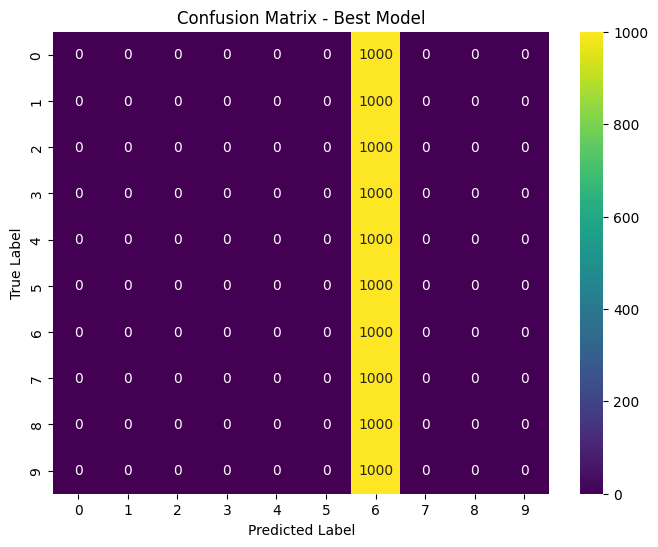

In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.datasets import fashion_mnist

# Best configuration from the sweep table
best_config = {
    "neurons": 128,
    "hidden_layers": 3,
    "input_size": 784,
    "output_size": 10,
    "weight_init": "xavier",
    "output_activation": "softmax",
    "activation": "sigmoid",
    "learning_rate": 0.001,
    "batch_size": 64,
    "optimizer": "nadam",
    "momentum": 0.8,
    "decay": 0,
    "loss": "cross_entropy",
    "beta": 0.9,
    "beta1": 0.9,
    "beta2": 0.999,
    "epsilon": 1e-8,
    "dataset": "fashion_mnist"
}

# Activation function mapping
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
act_funcs = {"sigmoid": sigmoid}

# Define the Feed_Forward model (for inference)
class Feed_Forward:
    def __init__(self, hidden_units, num_hidden_layers, input_dim, output_dim,
                 weight_init="random", output_activation="softmax", initialize=True):
        self.hidden_units = hidden_units
        self.num_hidden_layers = num_hidden_layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weight_init_type = weight_init
        self.output_activation_type = output_activation
        self.weights, self.biases = [], []
        if initialize:
            self.initialize_parameters()
    def initialize_parameters(self):
        self.weights.append(np.random.randn(self.input_dim, self.hidden_units))
        for _ in range(self.num_hidden_layers - 1):
            self.weights.append(np.random.randn(self.hidden_units, self.hidden_units))
        self.weights.append(np.random.randn(self.hidden_units, self.output_dim))
        if self.weight_init_type.lower() == "xavier":
            for i in range(len(self.weights)):
                self.weights[i] *= np.sqrt(1 / self.weights[i].shape[0])
        self.biases = [np.zeros(self.hidden_units) for _ in range(self.num_hidden_layers)]
        self.biases.append(np.zeros(self.output_dim))
    def predict(self, x, activation_func):
        self.pre_activation = [x]
        self.post_activation = [x]
        a = x
        for i in range(self.num_hidden_layers):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            self.pre_activation.append(z)
            a = activation_func(z)
            self.post_activation.append(a)
        z = np.dot(a, self.weights[-1]) + self.biases[-1]
        self.pre_activation.append(z)
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        a_out = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        self.post_activation.append(a_out)
        return a_out

# Load test data from Fashion MNIST
(_, _), (x_test, y_test) = fashion_mnist.load_data()
x_test = x_test.reshape(x_test.shape[0], 784) / 255.0
y_test = np.eye(10)[y_test]

# Instantiate the model using the best config
nn_best = Feed_Forward(hidden_units=best_config["neurons"],
                       num_hidden_layers=best_config["hidden_layers"],
                       input_dim=best_config["input_size"],
                       output_dim=best_config["output_size"],
                       weight_init=best_config["weight_init"],
                       output_activation=best_config["output_activation"],
                       initialize=True)

# Get predictions on the test set
act_func = act_funcs[best_config["activation"]]
y_pred_test = nn_best.predict(x_test, act_func)

# Compute test accuracy
test_accuracy = np.sum(np.argmax(y_pred_test, axis=1) == np.argmax(y_test, axis=1)) / y_test.shape[0]
print("Best Model Test Accuracy: {:.4f}".format(test_accuracy))

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_test, axis=1))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
plt.title("Confusion Matrix - Best Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
